In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import pandas as pd
import tensorflow as tf

In [58]:
data_path = "historical_air_quality_2021_vi.csv"
df = pd.read_csv(data_path)

df['Thời gian cập nhật'] = pd.to_datetime(
    df['Thời gian cập nhật'].str.strip(), 
    errors='coerce',
    infer_datetime_format=True,
    dayfirst=False  # Nếu dữ liệu theo kiểu Mỹ (MM/DD/YYYY), giữ False
)

df = df.dropna(subset=['Thời gian cập nhật'])
df['Thời điểm'] = df['Thời gian cập nhật'].dt.floor('H')

df = df.drop_duplicates(subset=['Mã trạm', 'Thời điểm'], keep='last').reset_index(drop=True)
df = df.sort_values(by=['Mã trạm', 'Thời điểm'])

print(df.shape)
df.head(5)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20964\2199177617.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Thời gian cập nhật'] = pd.to_datetime(


(2116, 22)


C:\Users\Admin\AppData\Local\Temp\ipykernel_20964\2199177617.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Thời điểm'] = df['Thời gian cập nhật'].dt.floor('H')


,Mã trạm,Chỉ số AQI,Vị trí,Tên trạm,Url,Chất ô nhiễm chủ đạo,CO,Sương,Độ ẩm,NO2,...,Bụi PM10,Bụi PM2.5,SO2,Nhiệt độ,Tốc độ gió,Thời gian cập nhật,Múi giờ,Trạng thái cảnh báo,Mức độ cảnh báo,Thời điểm
16,1584,0,"16.074,108.217","Da Nang, Vietnam (TP Đà Nẵng)",https://aqicn.org/city/vietnam/da-nang,NaN,3,0.0,88.0,1,...,-,-,5,21.0,4.6,2021-01-21 19:00:00,+07:00,#NAME?,#NAME?,2021-01-21 19:00:00
39,1584,0,"16.074,108.217","Da Nang, Vietnam (TP Đà Nẵng)",https://aqicn.org/city/vietnam/da-nang,NaN,2,0.0,78.0,1,...,-,-,6,22.5,7.9,2021-01-22 13:00:00,+07:00,#NAME?,#NAME?,2021-01-22 13:00:00
61,1584,-,"16.074,108.217","Da Nang, Vietnam (TP Đà Nẵng)",https://aqicn.org/city/vietnam/da-nang,NaN,3,0.0,68.5,1,...,-,-,6,23.5,5.4,2021-01-23 15:00:00,+07:00,#NAME?,#NAME?,2021-01-23 15:00:00
83,1584,-,"16.074,108.217","Da Nang, Vietnam (TP Đà Nẵng)",https://aqicn.org/city/vietnam/da-nang,NaN,9,0.0,78.0,1,...,-,-,6,23.0,1.5,2021-01-25 19:00:00,+07:00,#NAME?,#NAME?,2021-01-25 19:00:00
106,1584,-,"16.074,108.217","Da Nang, Vietnam (TP Đà Nẵng)",https://aqicn.org/city/vietnam/da-nang,NaN,3,0.0,78.0,1,...,-,-,6,24.0,4.6,2021-01-26 16:00:00,+07:00,#NAME?,#NAME?,2021-01-26 16:00:00


In [59]:
df_unique = df

In [60]:
# =========================================
# 4️⃣ Chọn các cột cảm biến liên quan đến thiết bị TinyML
# =========================================
# Giả sử cảm biến bạn có: DHT22 (Nhiệt độ, Độ ẩm), MQ135 (CO), cảm biến bụi (PM2.5)
cols = ['Nhiệt độ', 'Độ ẩm', 'CO', 'Bụi PM2.5', 'Chỉ số AQI']
data = df_unique[cols].copy()

print("Các cột được chọn:", data.columns.tolist())

# =========================================
# 5️⃣ Loại bỏ các giá trị thiếu hoặc không hợp lệ
# =========================================
# Thay thế ký tự '-' hoặc chuỗi rỗng bằng NaN
data = data.replace('-', pd.NA)
data = data.dropna(subset=['Chỉ số AQI'])

# Chuyển tất cả về dạng số
data = data.apply(pd.to_numeric, errors='coerce')
for col in data.columns:
    if col != 'Chỉ số AQI':
        print(f"-> Xử lý cột: {col} ...")
        print(f"Trước khi xử lý, số lượng NA: {data[col].isna().sum()}, giá trị mean: {data[col].mean()}")
        data[col] = data[col].fillna(data[col].mean())

print("✅ Số lượng hàng còn lại:", len(data))
print("✅ Còn NA nào không?")
print(data.isna().sum())

Các cột được chọn: ['Nhiệt độ', 'Độ ẩm', 'CO', 'Bụi PM2.5', 'Chỉ số AQI']
-> Xử lý cột: Nhiệt độ ...
Trước khi xử lý, số lượng NA: 0, giá trị mean: 25.720036652412947
-> Xử lý cột: Độ ẩm ...
Trước khi xử lý, số lượng NA: 0, giá trị mean: 75.70323762981063
-> Xử lý cột: CO ...
Trước khi xử lý, số lượng NA: 318, giá trị mean: 7.644275966641395
-> Xử lý cột: Bụi PM2.5 ...
Trước khi xử lý, số lượng NA: 33, giá trị mean: 68.75068578553616
✅ Số lượng hàng còn lại: 1637
✅ Còn NA nào không?
Nhiệt độ      0
Độ ẩm         0
CO            0
Bụi PM2.5     0
Chỉ số AQI    0
dtype: int64


In [61]:
# 4. Chuyển đổi sang kiểu số và tạo NaN cho lỗi
features_col = ['Nhiệt độ', 'Độ ẩm', 'CO', 'Bụi PM2.5']
target_col = 'Chỉ số AQI'

data = df_unique[features_col + [target_col]].copy()

print("Các cột được chọn:", data.columns.tolist())
print("Kích thước dữ liệu ban đầu:", data.shape)
data.replace('-', pd.NA, inplace=True)
data.replace('#NAME?', pd.NA, inplace=True) # Thêm cả giá trị lỗi phổ biến này

for col in features_col + [target_col]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# LOẠI BỎ HÀNG THIẾU Y (Chỉ số AQI)
data.dropna(subset=[target_col], inplace=True)

print(f"---\nSố lượng NaN trước khi nội suy:\n{data[features_col].isna().sum()}")
print(f"---\nTỉ lệ NaN trước khi nội suy:\n{data[features_col].isna().mean()}")

for col in features_col:
    # 1. Thực hiện Nội suy Tuyến tính
    # Nội suy giá trị thiếu dựa trên các điểm dữ liệu trước và sau
    data[col].interpolate(method='linear', limit_direction='both', inplace=True)
    
    # 2. Xử lý phần dữ liệu vẫn còn thiếu (nếu toàn bộ chuỗi là NaN)
    # Rất hiếm, nhưng nếu xảy ra, ta có thể dùng mean imputation cho những giá trị còn lại này.
    if data[col].isnull().any():
        data[col].fillna(data[col].mean(), inplace=True)

# Kiểm tra lại số lượng NaN sau khi xử lý
print("---\nSố lượng NaN sau khi nội suy:")
print(data[features_col].isnull().sum())

Các cột được chọn: ['Nhiệt độ', 'Độ ẩm', 'CO', 'Bụi PM2.5', 'Chỉ số AQI']
Kích thước dữ liệu ban đầu: (2116, 5)
---
Số lượng NaN trước khi nội suy:
Nhiệt độ       0
Độ ẩm          0
CO           318
Bụi PM2.5     33
dtype: int64
---
Tỉ lệ NaN trước khi nội suy:
Nhiệt độ     0.000000
Độ ẩm        0.000000
CO           0.194258
Bụi PM2.5    0.020159
dtype: float64
---
Số lượng NaN sau khi nội suy:
Nhiệt độ     0
Độ ẩm        0
CO           0
Bụi PM2.5    0
dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_20964\3306126255.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].interpolate(method='linear', limit_direction='both', inplace=True)


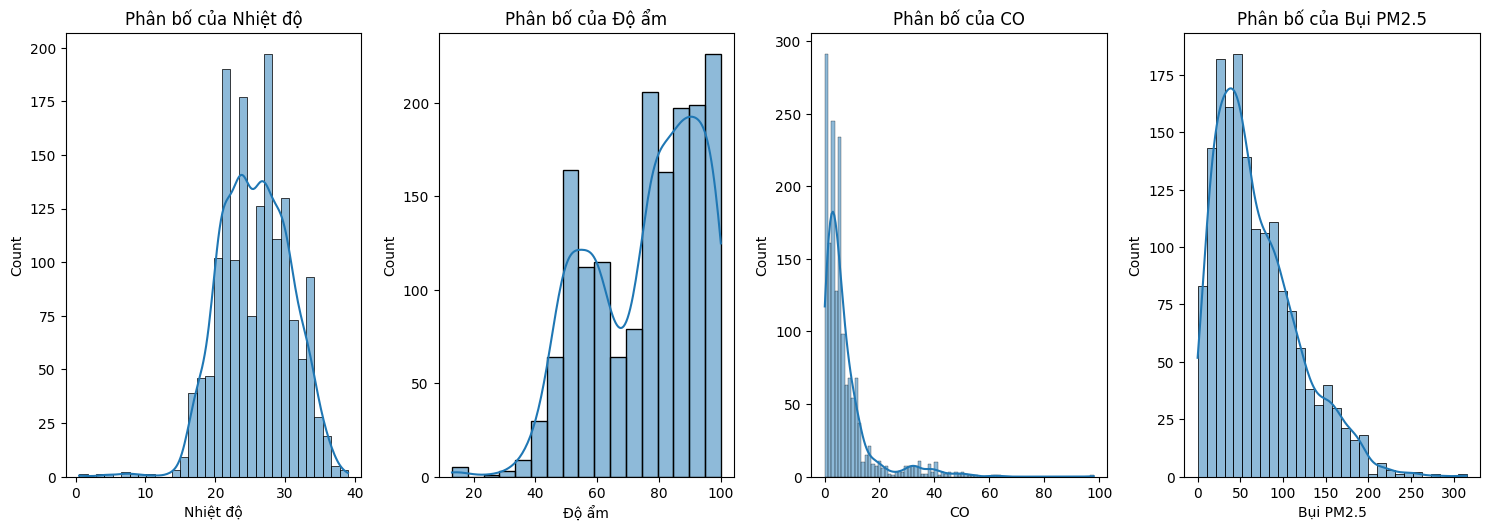

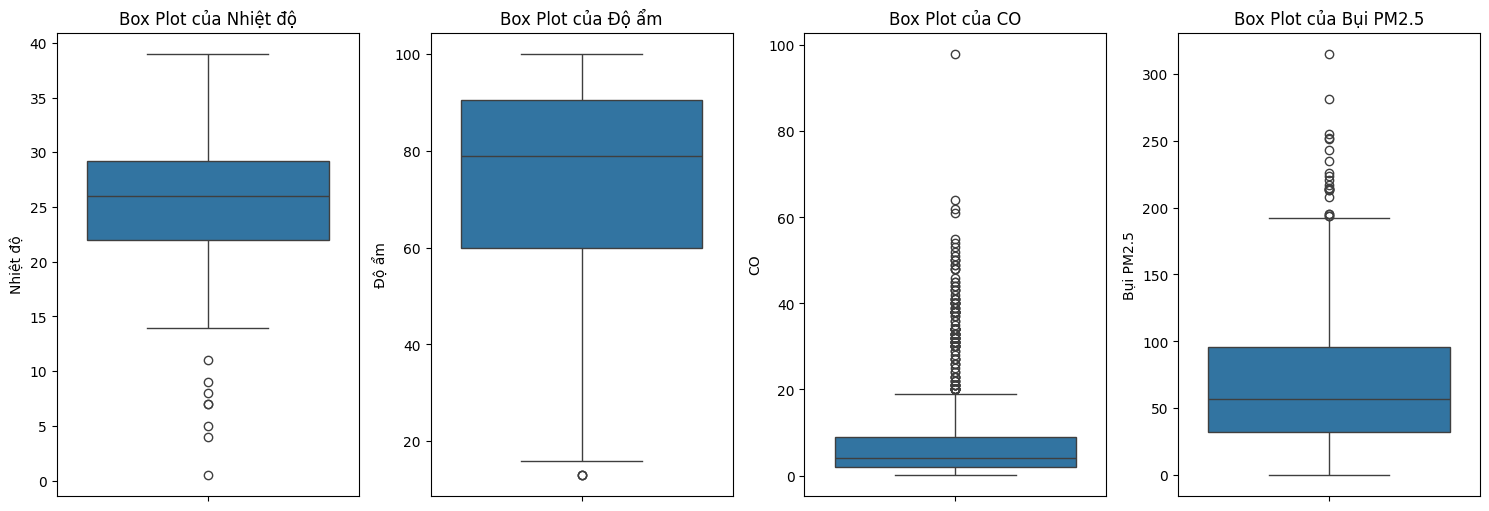

Cột Nhiệt độ bị loại bỏ 8 ngoại lai.
Cột Độ ẩm bị loại bỏ 3 ngoại lai.
Cột CO bị loại bỏ 128 ngoại lai.
Cột Bụi PM2.5 bị loại bỏ 34 ngoại lai.


In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

## Phân bố (Histograms)
plt.figure(figsize=(15, 10))
for i, col in enumerate(features_col):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Phân bố của {col}', fontsize=12)
plt.tight_layout()
plt.show()

## Ngoại lai (Box Plots)
plt.figure(figsize=(15, 10))
for i, col in enumerate(features_col):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(y=data[col])
    plt.title(f'Box Plot của {col}', fontsize=12)
plt.tight_layout()
plt.show()

# Lọc ngoại lai bằng IQR
def remove_outliers_iqr(df, feature_cols):
    for col in feature_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Hiển thị số lượng ngoại lai bị loại bỏ của từng cột
        initial_count = df.shape[0]
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        removed_count = initial_count - df.shape[0]
        print(f"Cột {col} bị loại bỏ {removed_count} ngoại lai.")
    return df

df_filtered = remove_outliers_iqr(data, features_col)

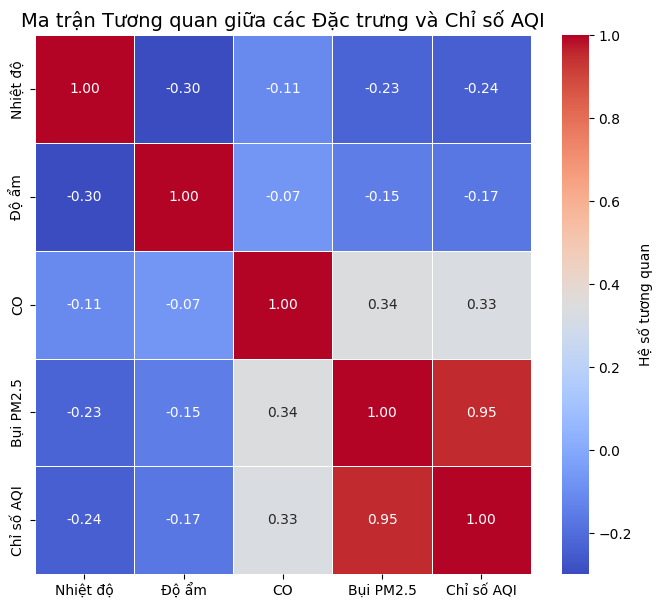

In [63]:
plt.figure(figsize=(8, 7))
# Tính ma trận tương quan
corr_matrix = df_filtered[features_col + [target_col]].corr()

# Vẽ Heatmap
sns.heatmap(corr_matrix, 
            annot=True,          # Hiển thị giá trị tương quan
            cmap='coolwarm',     # Sắc thái màu
            fmt=".2f",           # Định dạng 2 chữ số thập phân
            linewidths=.5,
            cbar_kws={'label': 'Hệ số tương quan'})
plt.title('Ma trận Tương quan giữa các Đặc trưng và Chỉ số AQI', fontsize=14)
plt.show()

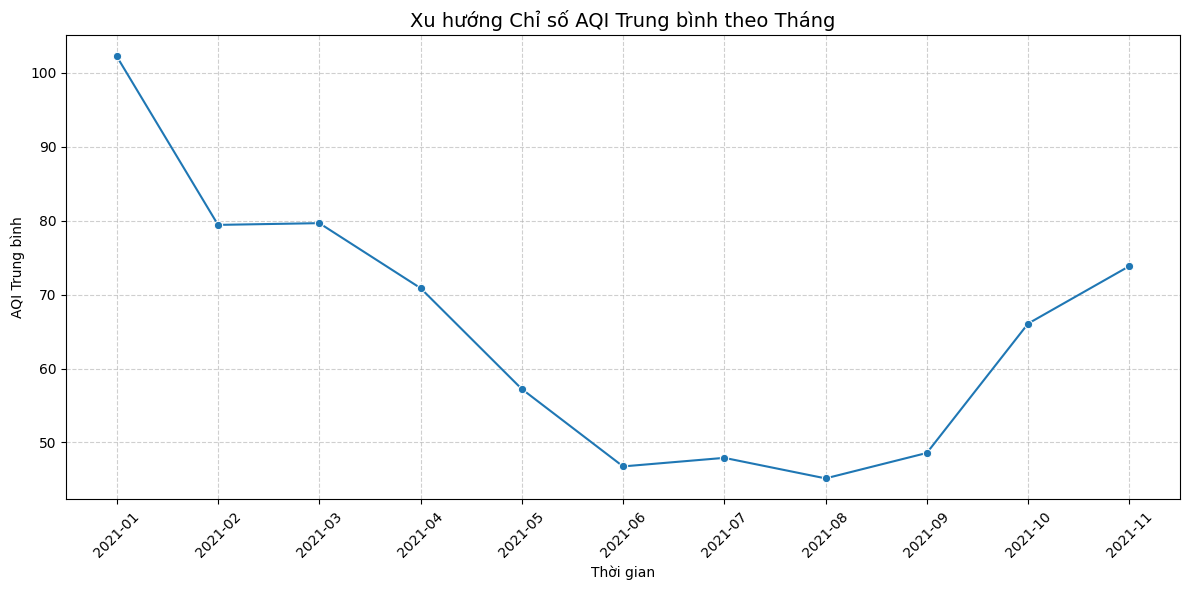

In [33]:
df_merged = df_filtered.merge(df[['Thời điểm']], left_index=True, right_index=True)

# Lấy trung bình hàng tháng (hoặc hàng tuần)
df_merged['Năm_Tháng'] = df_merged['Thời điểm'].dt.to_period('M')

# Tính AQI trung bình hàng tháng
monthly_aqi = df_merged.groupby('Năm_Tháng')['Chỉ số AQI'].mean().reset_index()
monthly_aqi['Năm_Tháng'] = monthly_aqi['Năm_Tháng'].astype(str) # Chuyển về chuỗi để vẽ

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_aqi, x='Năm_Tháng', y='Chỉ số AQI', marker='o')
plt.title('Xu hướng Chỉ số AQI Trung bình theo Tháng', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('AQI Trung bình')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_20964\920286175.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hourly_aqi, x='Giờ', y='Chỉ số AQI', palette='viridis')
C:\Users\Admin\AppData\Local\Temp\ipykernel_20964\920286175.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=daily_aqi, x='Ngày_trong_tuần', y='Chỉ số AQI', palette='plasma')


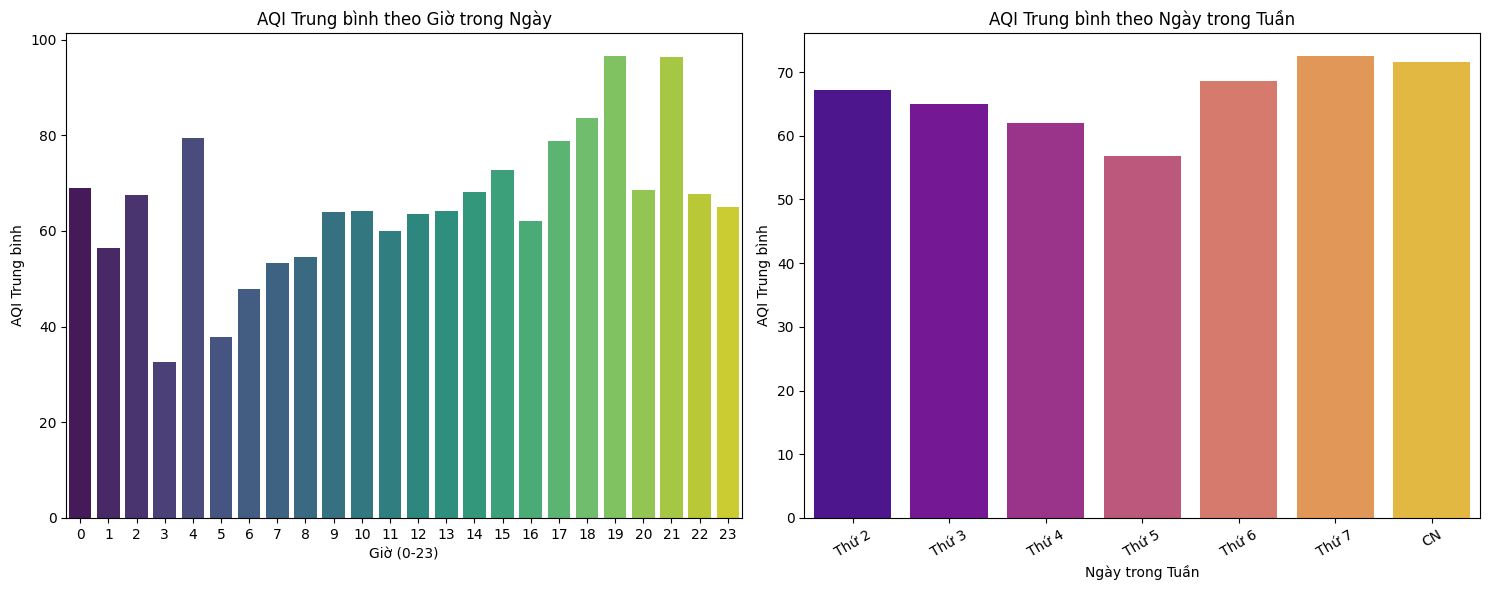

In [35]:
plt.figure(figsize=(15, 6))

# A. Chu kỳ theo Giờ trong ngày
plt.subplot(1, 2, 1)
df_merged['Giờ'] = df_merged['Thời điểm'].dt.hour
df_merged['Ngày_trong_tuần'] = df_merged['Thời điểm'].dt.dayofweek

hourly_aqi = df_merged.groupby('Giờ')['Chỉ số AQI'].mean().reset_index()
sns.barplot(data=hourly_aqi, x='Giờ', y='Chỉ số AQI', palette='viridis')
plt.title('AQI Trung bình theo Giờ trong Ngày', fontsize=12)
plt.xlabel('Giờ (0-23)')
plt.ylabel('AQI Trung bình')

# B. Chu kỳ theo Ngày trong tuần
plt.subplot(1, 2, 2)
# Đổi tên cho dễ đọc (Thứ 2=0, Chủ Nhật=6)
day_names = ['Thứ 2', 'Thứ 3', 'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'CN']
daily_aqi = df_merged.groupby('Ngày_trong_tuần')['Chỉ số AQI'].mean().reset_index()
sns.barplot(data=daily_aqi, x='Ngày_trong_tuần', y='Chỉ số AQI', palette='plasma')
plt.title('AQI Trung bình theo Ngày trong Tuần', fontsize=12)
plt.xlabel('Ngày trong Tuần')
plt.ylabel('AQI Trung bình')
plt.xticks(ticks=range(7), labels=day_names, rotation=30)

plt.tight_layout()
plt.show()

✅ X_train: (1309, 4), y_train: (1309, 1)
✅ X_val: (163, 4), y_val: (163, 1)
✅ X_test: (165, 4), y_test: (165, 1)
💾 Scaler_X và Scaler_y đã lưu thành công.


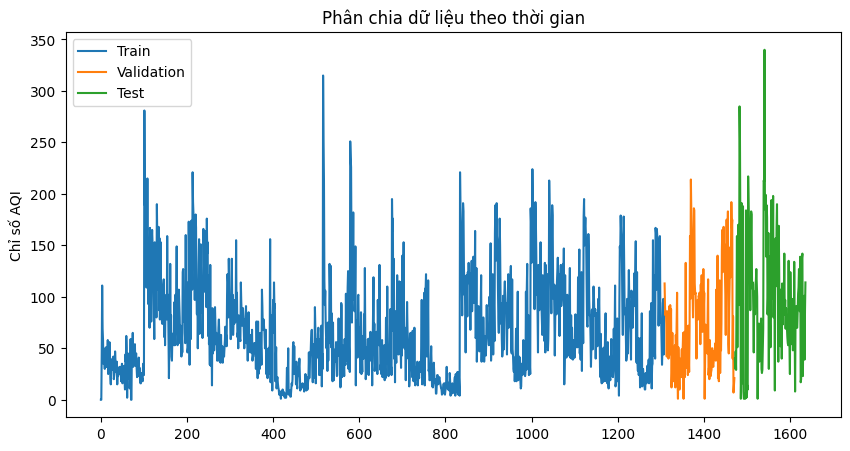

✅ Dữ liệu đã được chuẩn hóa và chia tách sẵn sàng cho huấn luyện GRU TinyML.


In [36]:
# =========================================
# ⚙️ Cấu hình chia dữ liệu
# =========================================
SPLIT = 0.8  # 80% train, 10% val, 10% test

train_size = int(len(data) * SPLIT)
val_size   = int(len(data) * 0.1)
test_size  = len(data) - train_size - val_size

# =========================================
# 1️⃣ Tách dữ liệu đầu vào (X) và đầu ra (y)
# =========================================
# Giả sử cột cuối là chỉ số AQI cần dự đoán
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]

# Chia tập Train / Val / Test
X_train = X.iloc[:train_size]
X_val   = X.iloc[train_size:train_size + val_size]
X_test  = X.iloc[-test_size:]

y_train = y.iloc[:train_size]
y_val   = y.iloc[train_size:train_size + val_size]
y_test  = y.iloc[-test_size:]

print(f"✅ X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"✅ X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"✅ X_test: {X_test.shape}, y_test: {y_test.shape}")

# =========================================
# 2️⃣ Chuẩn hóa dữ liệu về [0, 1]
# =========================================
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

# =========================================
# 3️⃣ Lưu scaler để dùng cho inference
# =========================================
joblib.dump(scaler_X, "scaler_X.save")
joblib.dump(scaler_y, "scaler_y.save")

print("💾 Scaler_X và Scaler_y đã lưu thành công.")

# =========================================
# 8️⃣ Kiểm tra trực quan dữ liệu
# =========================================
plt.figure(figsize=(10,5))
plt.plot(y_train['Chỉ số AQI'].values, label='Train')
plt.plot(range(len(X_train), len(X_train) + len(X_val)), y_val['Chỉ số AQI'].values, label='Validation')
plt.plot(range(len(X_train) + len(X_val), len(data)), y_test['Chỉ số AQI'].values, label='Test')
plt.legend()
plt.title('Phân chia dữ liệu theo thời gian')
plt.ylabel('Chỉ số AQI')
plt.show()

# =========================================
# ✅ Kết quả cuối: Dữ liệu sẵn sàng cho bước tạo chuỗi LSTM
# =========================================
print("✅ Dữ liệu đã được chuẩn hóa và chia tách sẵn sàng cho huấn luyện GRU TinyML.")

In [37]:
# =========================================
# 9️⃣ Tạo chuỗi dữ liệu dạng sliding window cho LSTM
# =========================================
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# ------------------------------
# Hàm tạo dataset sliding window
# ------------------------------
def create_sequences(X_scaled, y_scaled, lookback=24):
    """
    🔁 Tạo các chuỗi dữ liệu cho LSTM:
    - X: chứa các 'lookback' bước thời gian trước (dạng sliding window)
    - y: chứa giá trị tại thời điểm kế tiếp tương ứng
    
    Args:
        X_scaled (ndarray): Dữ liệu đầu vào đã chuẩn hóa, dạng (samples, features)
        y_scaled (ndarray): Nhãn đã chuẩn hóa, dạng (samples, 1)
        lookback (int): Số bước thời gian để nhìn lại (ví dụ 24 giờ)
    
    Returns:
        (X_seq, y_seq): tuple các mảng numpy phù hợp cho LSTM
    """
    X_seq, y_seq = [], []
    for i in range(lookback, len(X_scaled)):
        X_seq.append(X_scaled[i - lookback:i, :])   # lookback bước trước
        y_seq.append(y_scaled[i])                   # giá trị tại thời điểm hiện tại
    return np.array(X_seq), np.array(y_seq)


lookback = 24  # dùng 24 giờ gần nhất để dự đoán giá trị tiếp theo

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_val_seq, y_val_seq     = create_sequences(X_val_scaled,   y_val_scaled,   lookback)
X_test_seq, y_test_seq   = create_sequences(X_test_scaled,  y_test_scaled,  lookback)

print(f"✅ Dữ liệu Train: X = {X_train_seq.shape}, y = {y_train_seq.shape}")
print(f"✅ Dữ liệu Val:   X = {X_val_seq.shape}, y = {y_val_seq.shape}")
print(f"✅ Dữ liệu Test:  X = {X_test_seq.shape}, y = {y_test_seq.shape}")

✅ Dữ liệu Train: X = (1285, 24, 4), y = (1285, 1)
✅ Dữ liệu Val:   X = (139, 24, 4), y = (139, 1)
✅ Dữ liệu Test:  X = (141, 24, 4), y = (141, 1)


In [65]:
# =========================================
# 🔟 Xây dựng mô hình LSTM đơn giản
# =========================================
model = Sequential([
    GRU(32, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=False, unroll=True),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 32)             │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,193 (16.38 KB)

 Trainable params: 4,193 (16.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0343 - val_loss: 0.0285
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0225 - val_loss: 0.0224
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0200 - val_loss: 0.0174
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0162 - val_loss: 0.0177
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0152 - val_loss: 0.0169
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0147 - val_loss: 0.0163
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 - val_loss: 0.0162
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0140 - val_loss: 0.0166
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - val_loss: 0.0152
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0133 - val_loss: 0.0152
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

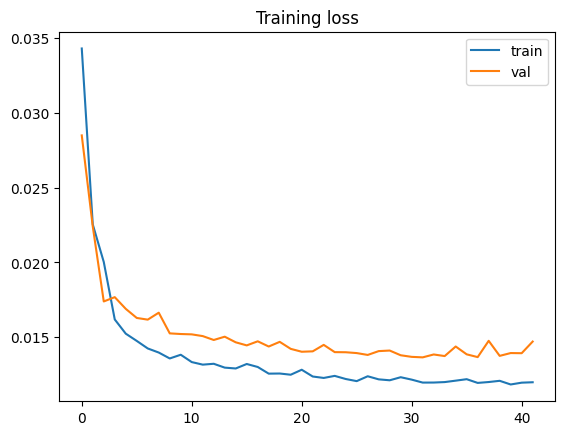

In [40]:
# =========================================
# 1️⃣1️⃣ Huấn luyện mô hình
# =========================================
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title("Training loss")
plt.show()


In [50]:
# =========================================
# 🔟 Đánh giá mô hình trên tập Test
# =========================================
# Sử dụng dữ liệu đã chuẩn hóa
test_loss = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"📉 Test Loss (MSE): {test_loss:.4f}")

# Dự đoán giá trị AQI đã chuẩn hóa
y_pred = model.predict(X_test_seq)

📉 Test Loss (MSE): 0.0254
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Tính toán các chỉ số
mae = mean_absolute_error(y_test_seq, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
r2 = r2_score(y_test_seq, y_pred)

print("--- Kết quả Đánh giá Hồi quy ---")
print(f"1. MAE (Mean Absolute Error): {mae:.3f}")
print(f"2. RMSE (Root Mean Squared Error): {rmse:.3f}")
print(f"3. R² Score: {r2:.4f}")

# Giải thích:
print("\nGiải thích:")
print(f"- MAE: Sai số dự đoán trung bình là {mae:.3f} đơn vị AQI.")
print(f"- RMSE: Sai số lớn hơn bị phạt nặng hơn, là {rmse:.3f} đơn vị AQI.")
print(f"- R²: Mô hình giải thích {r2*100:.2f}% sự biến thiên của Chỉ số AQI.")

--- Kết quả Đánh giá Hồi quy ---
1. MAE (Mean Absolute Error): 0.120
2. RMSE (Root Mean Squared Error): 0.159
3. R² Score: 0.1725

Giải thích:
- MAE: Sai số dự đoán trung bình là 0.120 đơn vị AQI.
- RMSE: Sai số lớn hơn bị phạt nặng hơn, là 0.159 đơn vị AQI.
- R²: Mô hình giải thích 17.25% sự biến thiên của Chỉ số AQI.


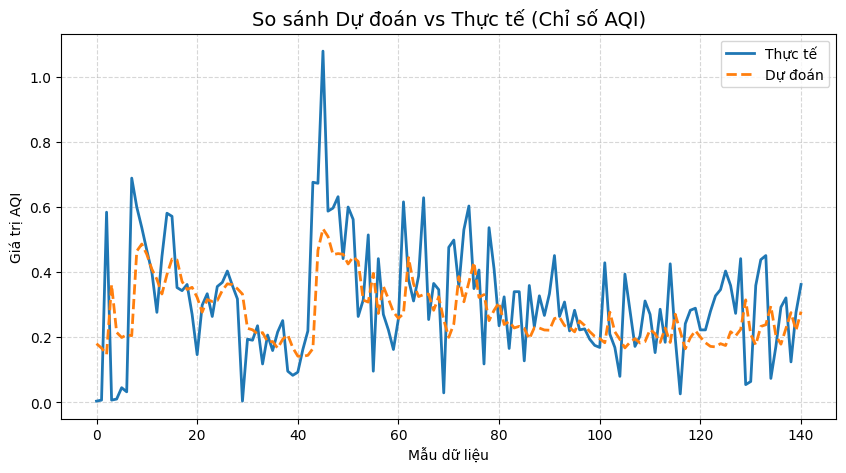

In [54]:
# =========================================
# 📊 Trực quan hóa kết quả
# =========================================
plt.figure(figsize=(10,5))
plt.plot(y_test_seq, label='Thực tế', linewidth=2)
plt.plot(y_pred, label='Dự đoán', linestyle='--', linewidth=2)
plt.title('So sánh Dự đoán vs Thực tế (Chỉ số AQI)', fontsize=14)
plt.xlabel('Mẫu dữ liệu')
plt.ylabel('Giá trị AQI')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

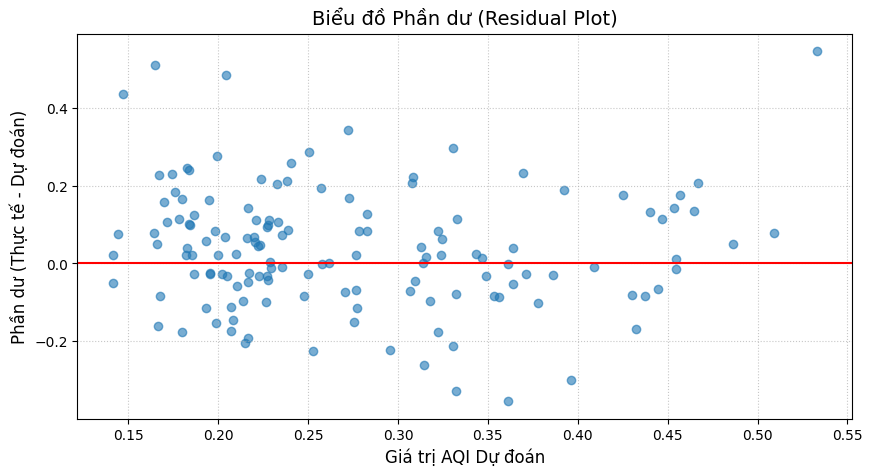

In [55]:
residuals = y_test_seq - y_pred

plt.figure(figsize=(10, 5))
# Vẽ phần dư so với giá trị dự đoán
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='-')

plt.title('Biểu đồ Phần dư (Residual Plot)', fontsize=14)
plt.xlabel('Giá trị AQI Dự đoán', fontsize=12)
plt.ylabel('Phần dư (Thực tế - Dự đoán)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

In [56]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Định nghĩa các mức cảnh báo AQI (Ví dụ đơn giản)
def aqi_to_level(aqi):
    if aqi <= 50:
        return 0  # Tốt
    elif aqi <= 100:
        return 1  # Trung bình
    else:
        return 2  # Xấu/Không lành mạnh

# Chuyển đổi giá trị AQI liên tục sang mức độ cảnh báo
y_test_levels = np.vectorize(aqi_to_level)(y_test_seq).flatten()
y_pred_levels = np.vectorize(aqi_to_level)(y_pred).flatten()

# Tính toán các chỉ số phân loại
conf_mat = confusion_matrix(y_test_levels, y_pred_levels)
accuracy = accuracy_score(y_test_levels, y_pred_levels)
precision = precision_score(y_test_levels, y_pred_levels, average='weighted', zero_division=0)
recall = recall_score(y_test_levels, y_pred_levels, average='weighted', zero_division=0)
f1 = f1_score(y_test_levels, y_pred_levels, average='weighted', zero_division=0)

print("\n--- Đánh giá Khả năng Phân loại (Cảnh báo) ---")
print("Ma trận Nhầm lẫn (Confusion Matrix):")
print(conf_mat)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


--- Đánh giá Khả năng Phân loại (Cảnh báo) ---
Ma trận Nhầm lẫn (Confusion Matrix):
[[141]]

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


d:\Semester\Ky_1_nam_4\venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [52]:
# =========================================
# 💾 Lưu mô hình để deploy TinyML
# =========================================
model.save("tinyml_gru_model.h5")
print("✅ Mô hình GRU đã lưu thành công → tinyml_gru_model.h5")

✅ Mô hình GRU đã lưu thành công → tinyml_gru_model.h5


In [ ]:
# =========================================
# 💾 Xuất mô hình sang SavedModel
# =========================================
MODEL_DIR = "gru_saved_model"
model.export(MODEL_DIR)

run_model = tf.function(lambda x: model(x))
BATCH_SIZE = 1
STEPS = X_train_seq.shape[1]
INPUT_SIZE = X_train_seq.shape[2]

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype)
)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS  # Bắt buộc cho RNN / GRU
]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

with open("gru_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Đã tạo file gru_model.tflite thành công!")

INFO:tensorflow:Assets written to: gru_saved_model\assets


INFO:tensorflow:Assets written to: gru_saved_model\assets


Saved artifact at 'gru_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 24, 4), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2735708150032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2735554520528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2735708147344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2735708148880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2735708149840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2735708149456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2735708149648: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Đã tạo file gru_model.tflite thành công!


In [44]:
# Load interpreter
interpreter = tf.lite.Interpreter(model_path="gru_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Lấy 1 mẫu test
test_input = X_test_seq[0:1].astype(np.float32)

# Gán input
interpreter.set_tensor(input_details[0]['index'], test_input)
interpreter.invoke()

# Lấy output
pred = interpreter.get_tensor(output_details[0]['index'])
pred_real = scaler_y.inverse_transform(pred)

print("📈 Dự đoán AQI:", pred_real.flatten()[0])

📈 Dự đoán AQI: 56.645317


d:\Semester\Ky_1_nam_4\venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [45]:
import edgeimpulse as ei
ei.API_KEY = "ei_421cf4154e5f600e4785811008bb7db9617c0d5d291db895d155738af88b9104"   # copy từ project Edge Impulse của bạn

# # profile model (tflite_model là bytes hoặc path)
# with open("aqi_model_quant.tflite","rb") as f:
#     tflite_bytes = f.read()

try:
    profile = ei.model.profile(model=tflite_model, device='espressif-esp32')
    print(profile.summary())
except Exception as e:
    print("Could not profile:", e)


Target results for float32:
{
    "variant": "float32",
    "device": "espressif-esp32",
    "tfliteFileSizeBytes": 100168,
    "isSupportedOnMcu": true,
    "memory": {
        "tflite": {
            "ram": 103382,
            "rom": 156840,
            "arenaSize": 102726
        },
        "eon": {
            "ram": 56440,
            "rom": 72536,
            "arenaSize": 30192
        }
    },
    "timePerInferenceMs": 235,
    "customMetrics": [],
    "hasPerformance": true
}


Performance on device types:
{
    "variant": "float32",
    "lowEndMcu": {
        "description": "Estimate for a Cortex-M0+ or similar, running at 40MHz",
        "timePerInferenceMs": 2667,
        "memory": {
            "tflite": {
                "ram": 101462,
                "rom": 148232
            },
            "eon": {
                "ram": 54840,
                "rom": 68376
            }
        },
        "supported": true
    },
    "highEndMcu": {
        "description": "Estimate for a

In [46]:
download_dir = "./"
deploy_filename = "gru_float32_model.zip"
# Create an Arduino library with trained model
deploy_bytes = None
try:
    deploy_bytes = ei.model.deploy(tflite_model,
                                   model_output_type=ei.model.output_type.Regression(),
                                   deploy_target='arduino')
except Exception as e:
    print(f"Could not deploy: {e}")
# Write the downloaded raw bytes to a file
if deploy_bytes:
    with open(deploy_filename, 'wb') as f:
        f.write(deploy_bytes.getvalue())

In [15]:
reshaped_test = X_test_seq[0].reshape(-1)

In [16]:
import sys
np.set_printoptions(threshold=sys.maxsize)
reshaped_test

array([0.65714286, 0.64942529, 0.40755873, 0.0952381 , 0.67792208,
       0.63218391, 0.34627171, 0.14920635, 0.54805195, 1.        ,
       0.3258427 , 0.09206349, 0.56883117, 0.51149425, 0.3258427 ,
       0.32698413, 0.6       , 0.96551724, 0.34627171, 0.48888889,
       0.75844156, 0.57931034, 0.38712972, 0.16190476, 0.75064935,
       0.6816092 , 0.34627171, 0.46349206, 0.51948052, 0.96551724,
       0.31562819, 0.53968254, 0.51168831, 0.96551724, 0.3258427 ,
       0.51111111, 0.53506494, 0.87931034, 0.34627171, 0.29206349,
       0.75844156, 0.62873563, 0.34627171, 0.80952381, 0.74805195,
       0.6816092 , 0.3360572 , 0.77142857, 0.84935065, 0.52413793,
       0.3360572 , 0.4984127 , 0.60779221, 0.91954023, 0.34627171,
       0.21825615, 0.73506494, 0.79195402, 0.45863126, 0.08571429,
       0.74805195, 0.75977011, 0.43820225, 0.31587302, 0.65974026,
       0.95977011, 0.45863126, 0.00825397, 0.68051948, 0.91494253,
       0.49948927, 0.06984127, 0.71428571, 0.85402299, 0.53013

In [26]:
reshaped_test.shape

(96,)

In [ ]:
from joblib import dump, load

X_scaler = load('scaler_X.save')
X_scaler.data_max_, X_scaler.data_min_, X_scaler.data_range_

(array([ 39., 100.,  98., 315.]),
 array([ 0.5, 13. ,  0.1,  0. ]),
 array([ 38.5,  87. ,  97.9, 315. ]))

In [ ]:
y_scaler = load('scaler_y.save')

y_scaler.data_max_, y_scaler.data_min_, y_scaler.data_range_

(array([315.]), array([1.]), array([314.]))

In [ ]:
data_max = y_scaler.data_max_[0]
data_min = y_scaler.data_min_[0]
value = 0.118
temp = value * (data_max - data_min) + data_min
temp

38.052